In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
# Specifically ignore Deprecation Warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Ignore future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-dataset-linear-regression/train_energy_data.csv
/kaggle/input/energy-consumption-dataset-linear-regression/test_energy_data.csv


In [2]:
data = pd.read_csv('/kaggle/input/energy-consumption-dataset-linear-regression/train_energy_data.csv')
data_test = pd.read_csv('/kaggle/input/energy-consumption-dataset-linear-regression/test_energy_data.csv')

In [3]:
data.isna().sum()

Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


In [5]:
cat=[]
for col in data.columns:
    if data[col].dtype == 'object':
        cat.append(col)
print(cat)

cont = [col for col in data.columns if col not in cat]
cont

['Building Type', 'Day of Week']


['Square Footage',
 'Number of Occupants',
 'Appliances Used',
 'Average Temperature',
 'Energy Consumption']

In [6]:
data.nunique()

Building Type             3
Square Footage          986
Number of Occupants      99
Appliances Used          49
Average Temperature     833
Day of Week               2
Energy Consumption     1000
dtype: int64

### EDA

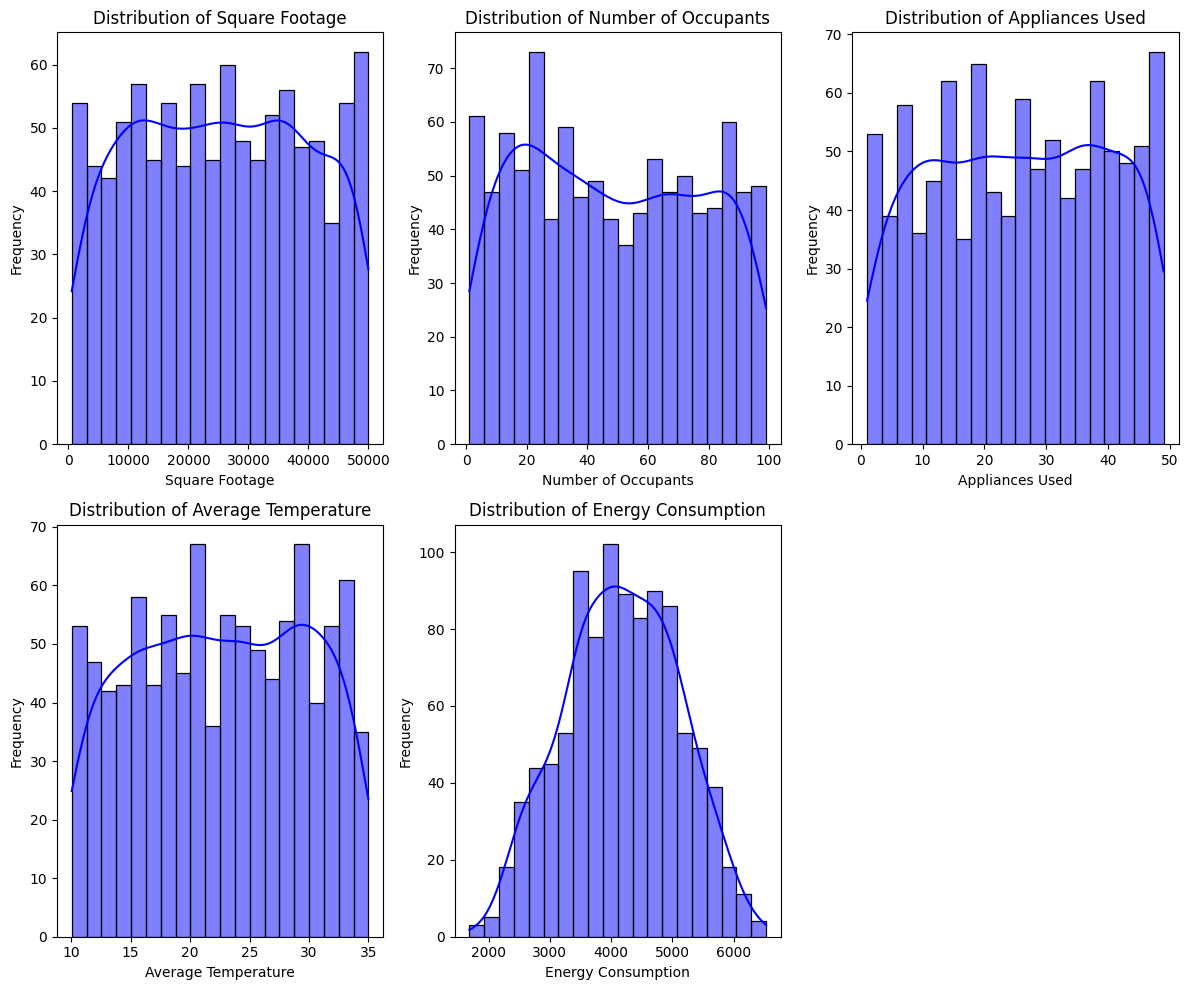

In [7]:
# Create distribution plots
plt.figure(figsize=(12, 10))
for i, col in enumerate(cont, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True, bins=20, color="blue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

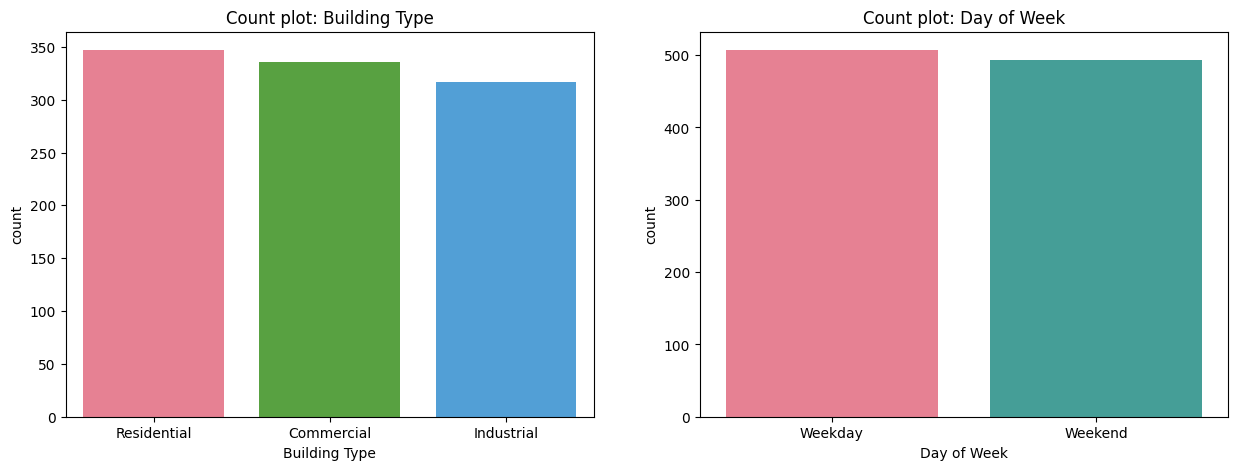

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.countplot(x='Building Type', data=data,ax=axes[0],palette='husl')
axes[0].set_title('Count plot: Building Type')

sns.countplot(x='Day of Week',data=data,ax=axes[1],palette='husl')
axes[1].set_title('Count plot: Day of Week')

plt.show()

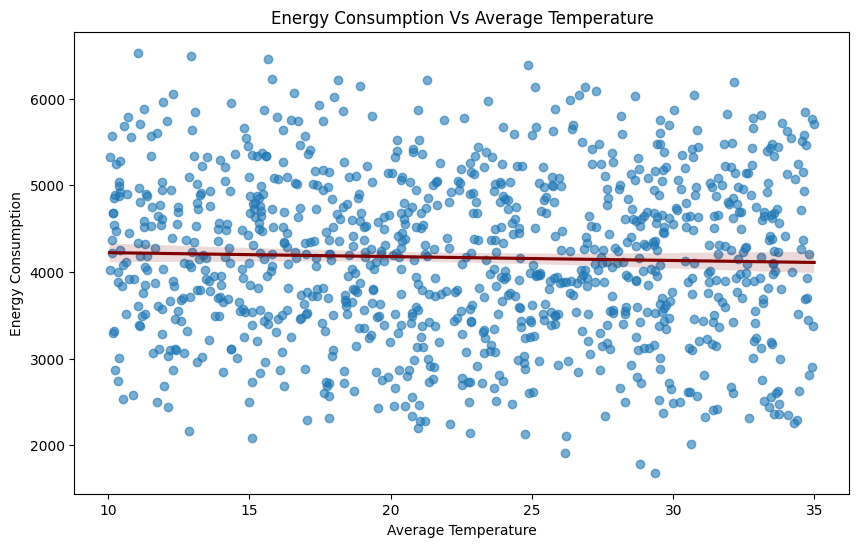

In [9]:
plt.figure(figsize=(10, 6))
sns.regplot(data=data, x='Average Temperature',y='Energy Consumption',scatter_kws={'alpha':0.6}, line_kws={'color':'maroon'})#,hue='Building Type',palette='husl')#size='Building Type',
plt.title("Energy Consumption Vs Average Temperature")
plt.show()

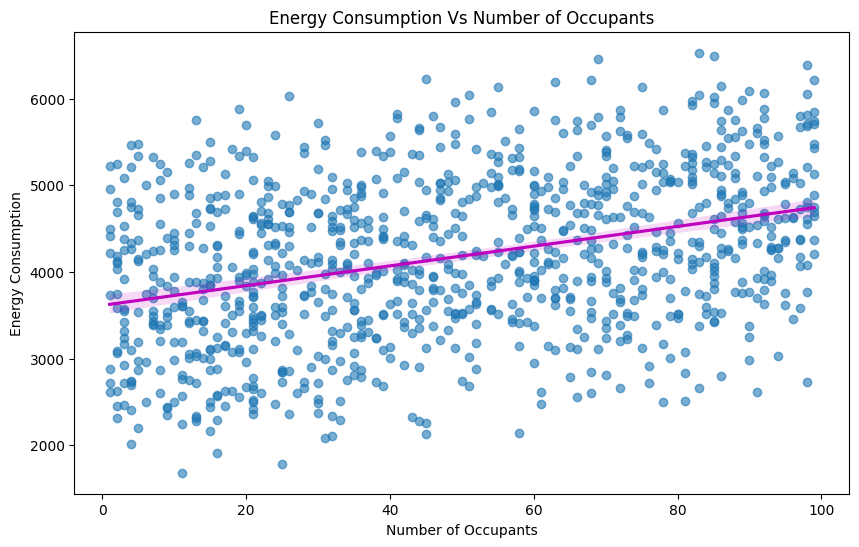

In [10]:
plt.figure(figsize=(10, 6))
sns.regplot(data=data, x='Number of Occupants',y='Energy Consumption',scatter_kws={'alpha':0.6}, line_kws={'color':'m'})#,hue='Building Type',palette='husl')#size='Building Type',
plt.title("Energy Consumption Vs Number of Occupants")
plt.show()

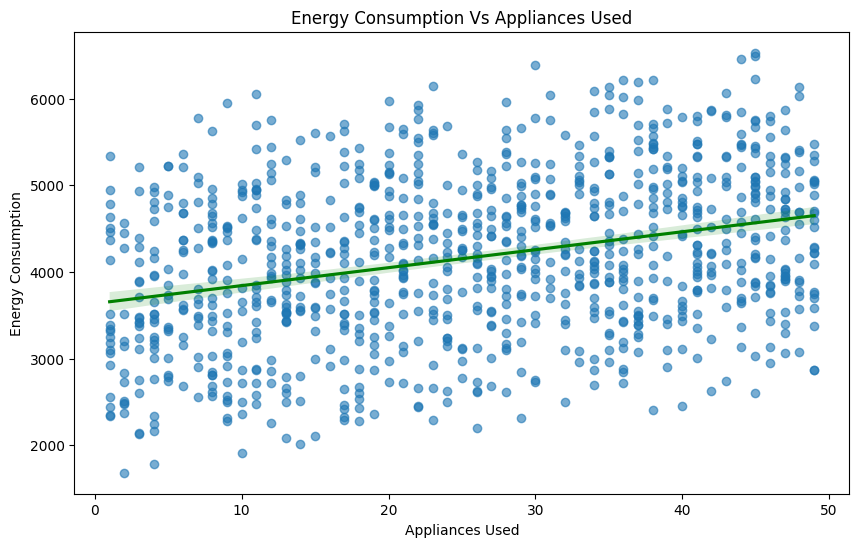

In [11]:
plt.figure(figsize=(10, 6))
sns.regplot(data=data, x='Appliances Used',y='Energy Consumption',scatter_kws={'alpha':0.6}, line_kws={'color':'green'})#,hue='Building Type',palette='husl')#size='Building Type',
plt.title("Energy Consumption Vs Appliances Used")
plt.show()

<Figure size 1500x1000 with 0 Axes>

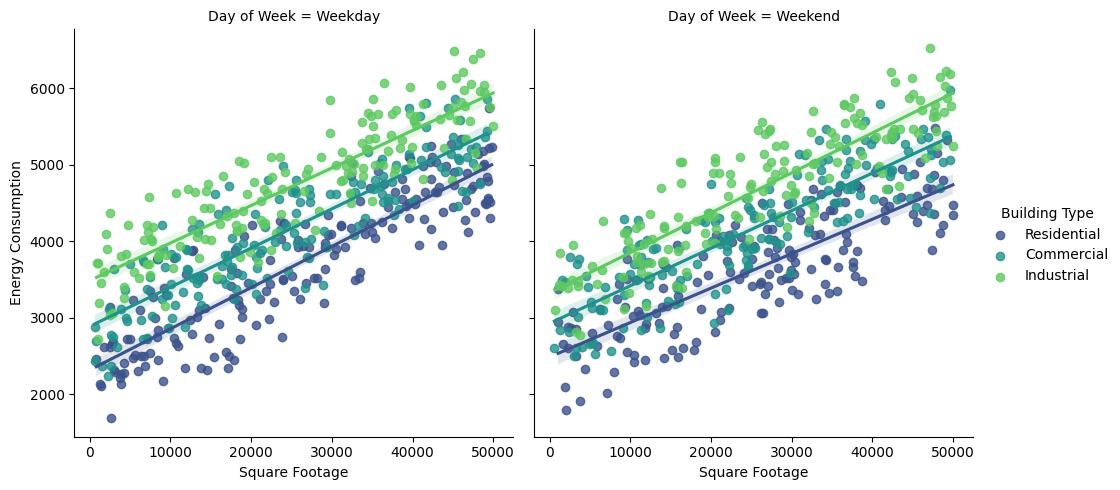

In [12]:
plt.figure(figsize=(15, 10))
sns.lmplot(data=data, x='Square Footage',y='Energy Consumption',hue='Building Type',col='Day of Week',palette='viridis')#size='Building Type',
plt.show()

In [13]:
#Creating a function to encode categorical variables
def dummies(df,cols):
    for col in cols:
        dummies = pd.get_dummies(df[col],dtype=int,prefix=col)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(labels=col, axis=1)
    return df

data = dummies(data,cat)

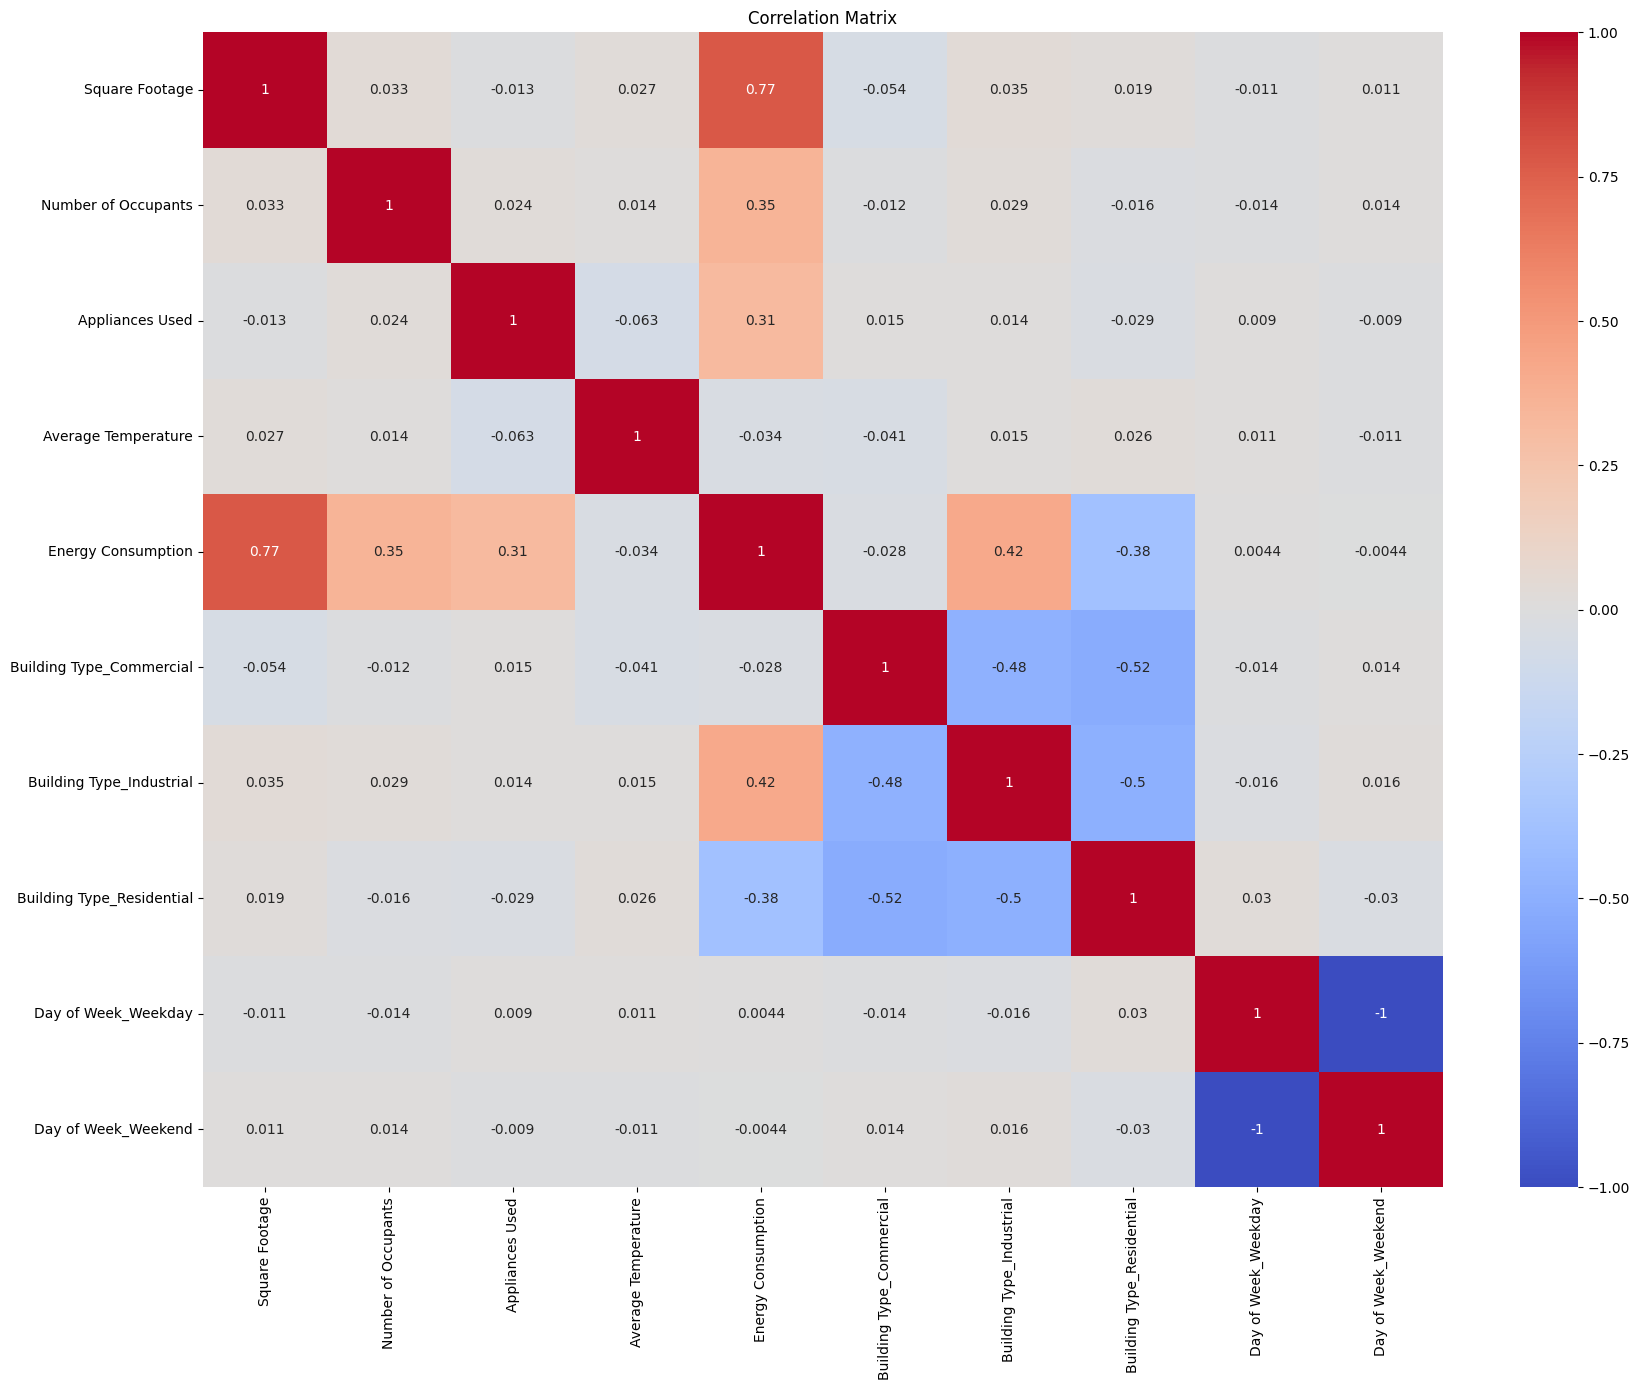

In [14]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, cmap='coolwarm', annot=True, ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

### Splitting data into train and validation set

In [15]:
X = data.drop('Energy Consumption',axis=1)
y = data['Energy Consumption']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape,X_val.shape)

(800, 9) (200, 9)


In [16]:
# Function to fit regression models
def evaluate_models(X_train,X_test,y_train,y_test):
    models={
        "Linear Regression":LinearRegression(),
        "Random Forest Regression":RandomForestRegressor(),
        "Decision Tree Regressor":DecisionTreeRegressor(),
        "K-Nearest Neighbours":KNeighborsRegressor()
    }
    result={}
    for name ,model in models.items():
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2=r2_score(y_test,y_pred)
        result[name]={"R2_Score":r2*100,"MSE":mse}
    

    result_frame=pd.DataFrame(result).T

    return result_frame

## Checking the model performance on validation set

In [17]:
result_frame_val=evaluate_models(X_train,X_val,y_train,y_val)
result_frame_val

,R2_Score,MSE
Linear Regression,100.000000,0.000189
Random Forest Regression,97.999943,16286.466604
Decision Tree Regressor,93.497398,52950.711399
K-Nearest Neighbours,54.564048,369985.094908


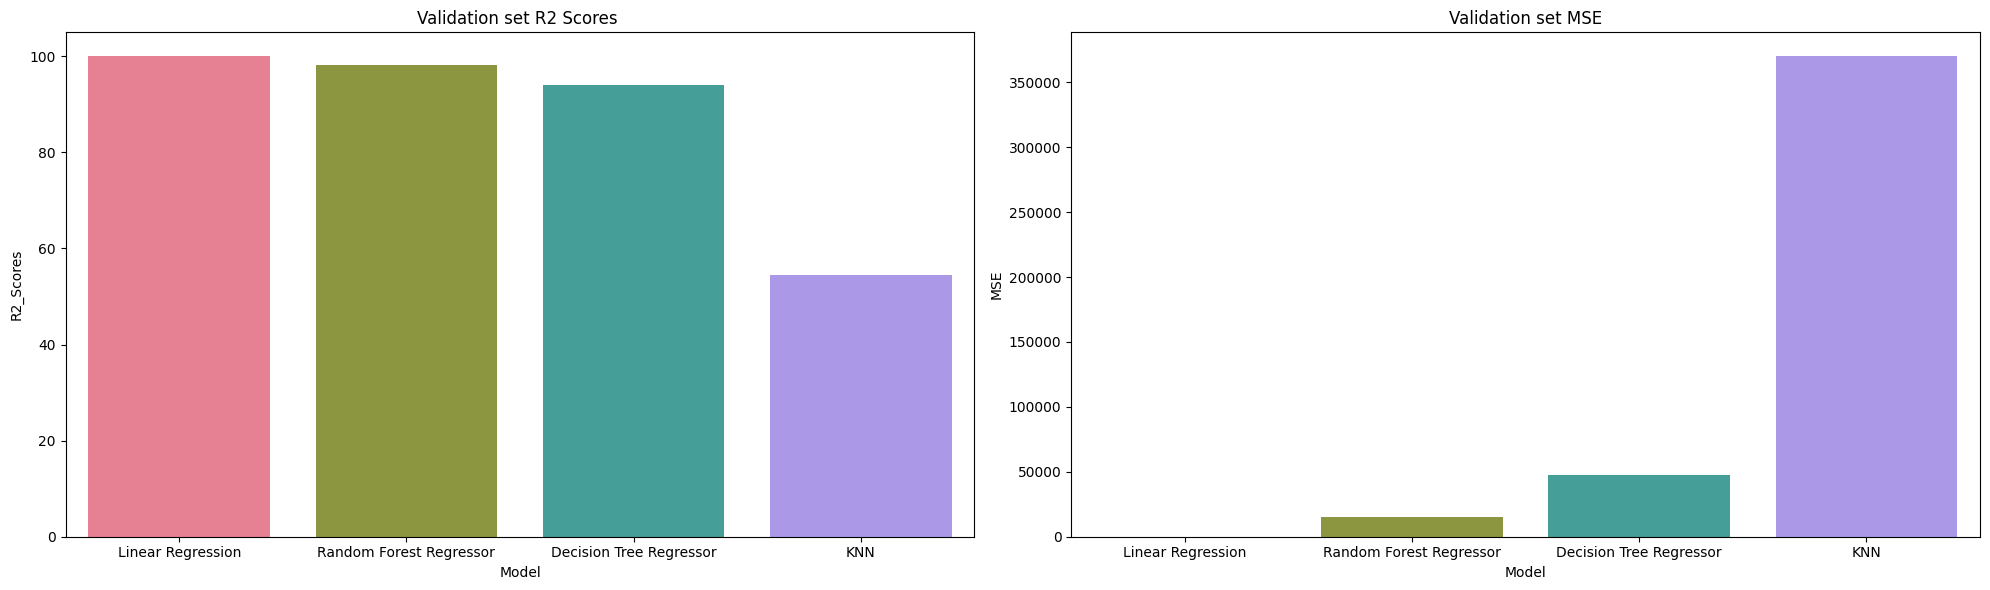

In [18]:
#Plot R2 and MSE
F_results = {
    "Model": ["Linear Regression", "Random Forest Regressor", "Decision Tree Regressor", "KNN"],
    "R2_Scores": [100, 98.1, 94.13, 54.56],
    "MSE":[0.000189,15521.25,47764.19,369985.09]
}

df_results = pd.DataFrame(F_results)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,6))

sns.barplot(data=df_results, x='Model', y='R2_Scores',ax=axes[0],palette='husl')
axes[0].set_title('Validation set R2 Scores ')
sns.barplot(data=df_results, x='Model', y='MSE',ax=axes[1],palette='husl')
axes[1].set_title('Validation set MSE')

plt.tight_layout()
plt.show()

## Checking the model performance on test set

In [19]:
data_test = dummies(data_test,cat)

X_test = data_test.drop('Energy Consumption',axis=1)
y_test= data_test['Energy Consumption']

In [20]:
result_frame_test=evaluate_models(X_train,X_test,y_train,y_test)
result_frame_test

,R2_Score,MSE
Linear Regression,100.000000,0.000201
Random Forest Regression,97.344553,18222.321864
Decision Tree Regressor,92.122211,54059.307199
K-Nearest Neighbours,35.425207,443127.950713


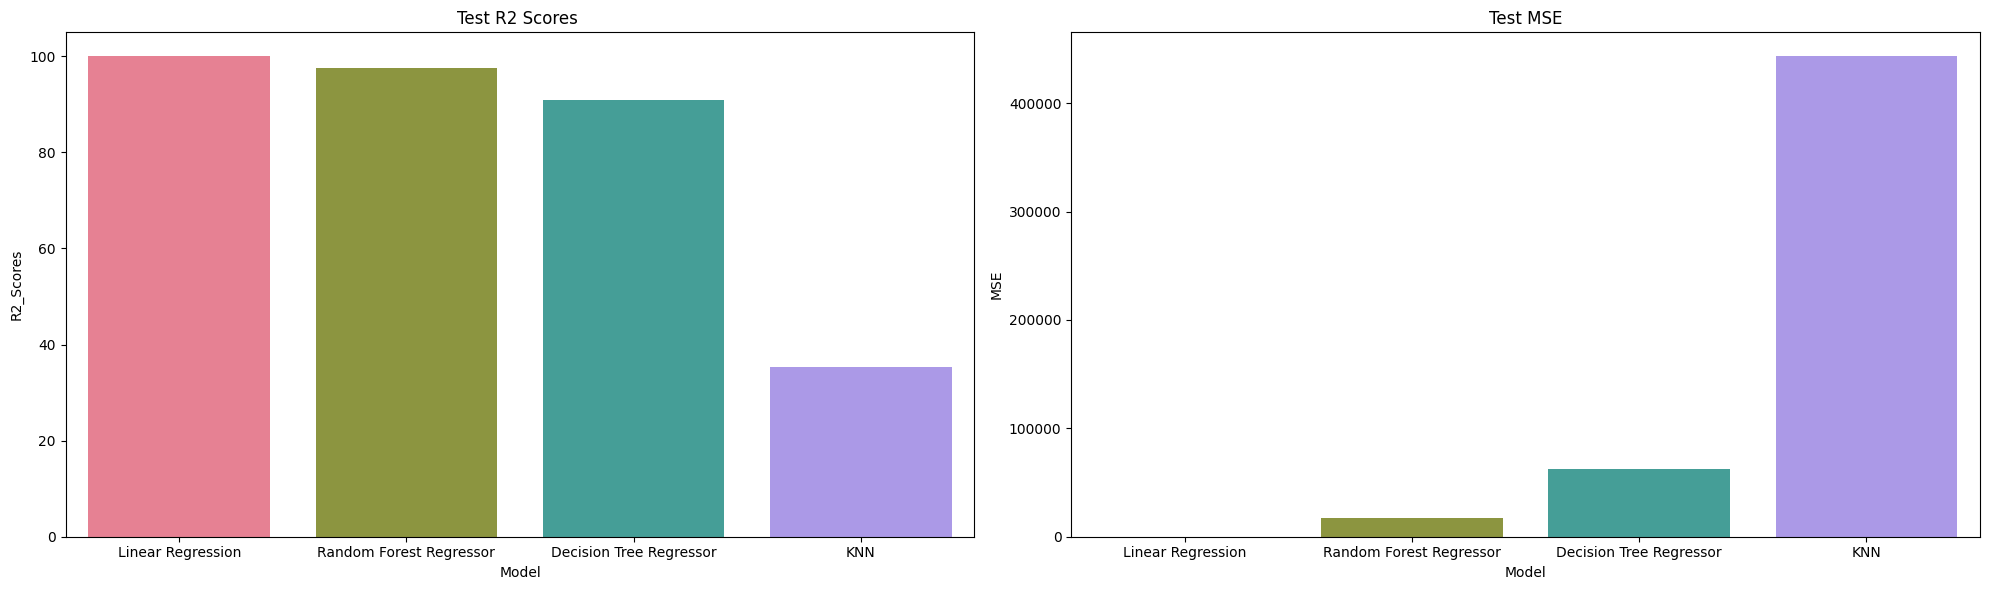

In [21]:
F_results = {
    "Model": ["Linear Regression", "Random Forest Regressor", "Decision Tree Regressor", "KNN"],
    "R2_Scores": [100, 97.54, 90.89, 35.42],
    "MSE":[0.000201,16825.89,62500.76,443127.95]
}

df_results = pd.DataFrame(F_results)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,6))

sns.barplot(data=df_results, x='Model', y='R2_Scores',ax=axes[0],palette='husl')
axes[0].set_title('Test R2 Scores ')
sns.barplot(data=df_results, x='Model', y='MSE',ax=axes[1],palette='husl')
axes[1].set_title('Test MSE')

plt.tight_layout()
plt.show()